In [2]:
# Activate virtual environment
# in cmd terminal
# cd C:\Users\Fred\Desktop\Capacity_Algo
# .\capa_algo\Scripts\activate
import Data_Conversion
import Passive_Model
import Solar_Generation
import Electrical_Load

import Simulate
import SO
import RO

import numpy as np
import pandas as pd
import os
from pathlib import Path

In [3]:
import Input_Parameters 

# Define the base data directory, list of locations, and the weather year.
data_dir = "Data"
# locations = ["HalfMoonBay", "Arizona", "Alaska", "Minnesota", "Florida"]
location = ["HalfMoonBay"]
scenarios = ["FOB", "RC", "DC"]

fold = 1 # testing data is 1998-2002, 2003-2007...
# Baseline capacity costs
capacity_costs = [Input_Parameters.C_PV, Input_Parameters.C_PV_OP, Input_Parameters.C_B, Input_Parameters.C_B_OP]

# 20 years of training data
weather_year_list = list(range(1998, 2003))  # The upper bound in range() is exclusive

# Set a random seed for consistency
# Define the number of rows (i) and columns (j)

j = len(weather_year_list)  # Number of columns

# Generate a sequential array of numbers starting from 1
total_cells = j  # Total number of cells in the DataFrame
sequential_numbers = np.arange(1, total_cells + 1)  # Generates 1, 2, 3, ..., i*j
random_seeds = sequential_numbers
# The base case should always be the first row of the random seed matrix, for sensitivity analysis on locations, scenarios, and capacity costs.

# Get the list of latitude, longitude, and timezones for all locations
lats, lons, timezones = Data_Conversion.get_timezones(data_dir, location)

# Create the nested dictionary to store all input data
nested_dict = {scenario: {year: {} for year in weather_year_list} for scenario in scenarios}

# Get all input data for each of the 25 years
for j in range(len(weather_year_list)):
    
    year = weather_year_list[j]
        
    # Get a unique random seed number
    random_seed = random_seeds[j]

    # Read NSRDB weather data of the given location of the given year
    # NSRDB_raw_weather = Data_Conversion.read_NSRDB(data_dir, location, year).head(24)
    NSRDB_raw_weather = Data_Conversion.read_NSRDB(data_dir, location[0], year)
    
    # Prepare weather data file using NSRDB data
    weather_data = Data_Conversion.prepare_NSRDB(NSRDB_raw_weather, lats[0], lons[0], timezones[0])

    # Prepare heating and cooling load using weather data and passive model
    NetHeatTransfers = Passive_Model.passive_model(Input_Parameters.calibration_file_path, weather_data, Input_Parameters.T_indoor_constant, lats[0])

    # Prepare solar PV capacity factor using weather data
    pv_cf = Solar_Generation.generate_pv(weather_data, lats[0])
    
    for i in range(len(scenarios)):
        
        scenario = scenarios[i]
        # Prepare occupancy and electrical load schedule using for a specific random seed number for a specific year at a specific scenario
        load_sched = Electrical_Load.generate_schedules(scenario, weather_data, random_seed)

        
        # Combine all relative input data as input_df, which will be the input of the capacity optimization algorithm
        input_df = Data_Conversion.combine_input_NSRDB(weather_data, load_sched, pv_cf, NetHeatTransfers)
        
        # Add input_df to list
        nested_dict[scenario][year] = input_df

Reading file for HalfMoonBay: Data\NREL_NSRDB_HalfMoonBay\137344_37.49_-122.42_1998.csv
Reading file for HalfMoonBay: Data\NREL_NSRDB_HalfMoonBay\137344_37.49_-122.42_1998.csv
Reading file for HalfMoonBay: Data\NREL_NSRDB_HalfMoonBay\137344_37.49_-122.42_1999.csv
Reading file for HalfMoonBay: Data\NREL_NSRDB_HalfMoonBay\137344_37.49_-122.42_2000.csv
Reading file for HalfMoonBay: Data\NREL_NSRDB_HalfMoonBay\137344_37.49_-122.42_2001.csv
Reading file for HalfMoonBay: Data\NREL_NSRDB_HalfMoonBay\137344_37.49_-122.42_2002.csv


In [4]:
# Define folder name
folder_name = "test"
# Create folder if it doesn't already exist
os.makedirs(folder_name, exist_ok=True)
algorithms = ["LP"]

In [5]:

import Baseline_CO
import matplotlib.pyplot as plt

In [6]:
print(nested_dict["DC"][2000])
df = nested_dict["DC"][2000]


                DateTime    Ta   pv  E_Load  Cooling_Load  Heating_Load
0    2000-01-01 00:30:00   9.8  0.0    91.8     90.223817      0.000000
1    2000-01-01 01:30:00   9.7  0.0    61.2     59.613362      0.000000
2    2000-01-01 02:30:00   9.8  0.0    91.8     90.218427      0.000000
3    2000-01-01 03:30:00   9.9  0.0    91.8     90.231546      0.000000
4    2000-01-01 04:30:00   9.8  0.0    61.2     59.621153      0.000000
...                  ...   ...  ...     ...           ...           ...
8755 2000-12-31 19:30:00  10.4  0.0     0.0      0.000000      1.513852
8756 2000-12-31 20:30:00  10.4  0.0     0.0      0.000000      1.519671
8757 2000-12-31 21:30:00  10.3  0.0     0.0      0.000000      2.055054
8758 2000-12-31 22:30:00  10.2  0.0     0.0      0.000000      2.066717
8759 2000-12-31 23:30:00  10.1  0.0     0.0      0.000000      2.109170

[8760 rows x 6 columns]


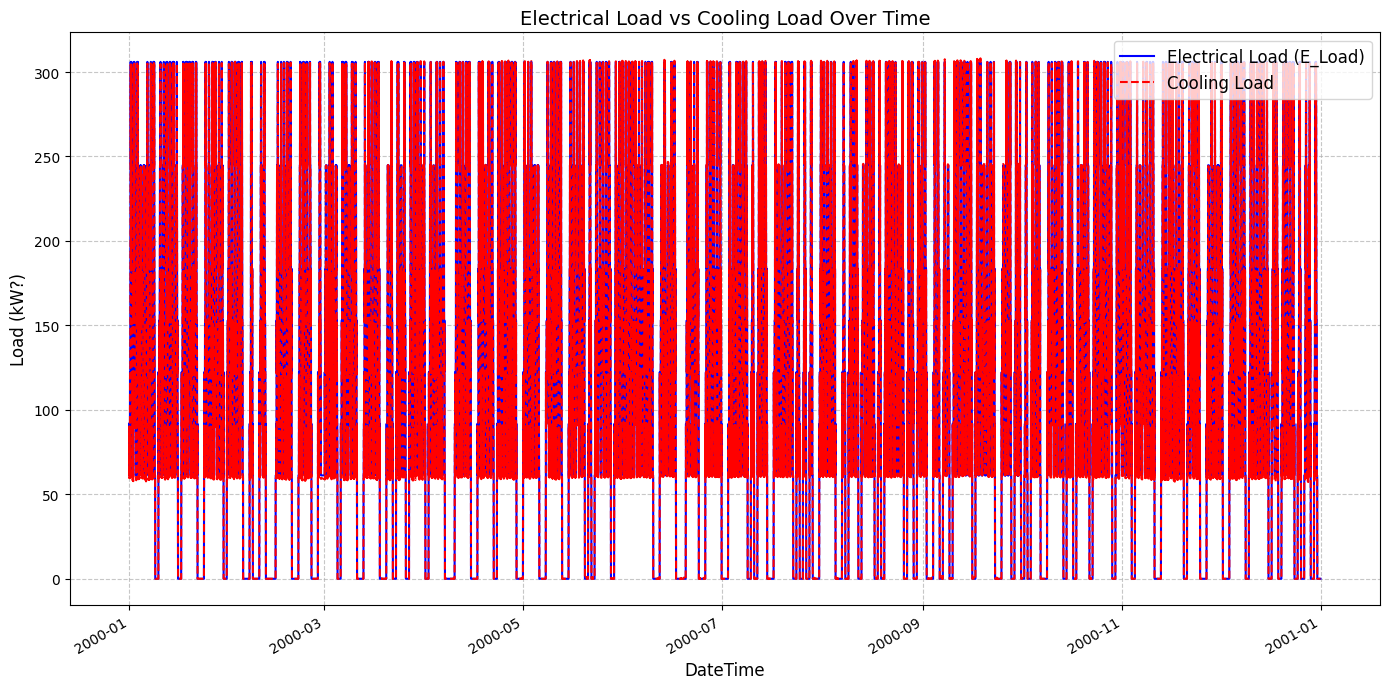

In [7]:
# Create the plot
plt.figure(figsize=(14, 7))

# Plot E_Load
plt.plot(df['DateTime'], df['E_Load'], 
         label='Electrical Load (E_Load)', 
         color='blue', 
         linewidth=1.5)

# Plot Cooling_Load
plt.plot(df['DateTime'], df['Cooling_Load'], 
         label='Cooling Load', 
         color='red', 
         linewidth=1.5,
         linestyle='--')

# Customize the plot
plt.title('Electrical Load vs Cooling Load Over Time', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Load (kW?)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate()  # Rotates dates for better readability

# Show plot
plt.tight_layout()
plt.show()

In [8]:
# Iterate through scenarios
scenario == 'DC'
lolc = 30
year = 2000
input_df = nested_dict[scenario][year]
# Run LP function
PV_Size, Battery_Size, PCM_Heating_Size, PCM_Cooling_Size, ObjValue, First_stage_cost, Second_stage_cost, HVAC_Cost, Critical_load_cost, solution_output = Baseline_CO.Cap_Baseline_V2(input_df, lolc, capacity_costs, scenario)


current scenario
DC
100
Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-02
Read LP format model from file C:\Users\Fred\AppData\Local\Temp\tmpoimy1b14.pyomo.lp
Reading time = 0.47 seconds
x1: 166443 rows, 166445 columns, 503669 nonzeros
Set parameter Threads to value 4
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 4 threads

Optimize a model with 166443 rows, 166445 columns and 503669 nonzeros
Model fingerprint: 0xfda1b5d9
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [8e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 3e+02]
Presolve removed 54861 rows and 68923 columns
Presolve time: 0.39s
Presolved: 111582 rows, 97522 columns, 493149 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Orderi

In [9]:
print("PV Size")
print(PV_Size)
print("Battery Size")
print(Battery_Size)
print("PCM H")
print(PCM_Heating_Size)
print("PCM C")
print(PCM_Cooling_Size)
print("Total Cost")
print(ObjValue)
print("Total Capital Cost")
print(First_stage_cost)
print("Total Operational Cost")
print(Second_stage_cost)
print("HVAC Cost")
print(HVAC_Cost)
print("E Cost")
print(Critical_load_cost)

PV Size
3367.127
Battery Size
6045.882
PCM H
0.0
PCM C
2788.908
Total Cost
707766.049
Total Capital Cost
653063.767
Total Operational Cost
54702.282
HVAC Cost
30715.155
E Cost
23987.127


In [10]:
print(sum(df['E_Load']))
print(sum(df['Cooling_Load']))
print(sum(df['pv'])*PV_Size)

976109.4
969906.2451380263
4985541.482321287


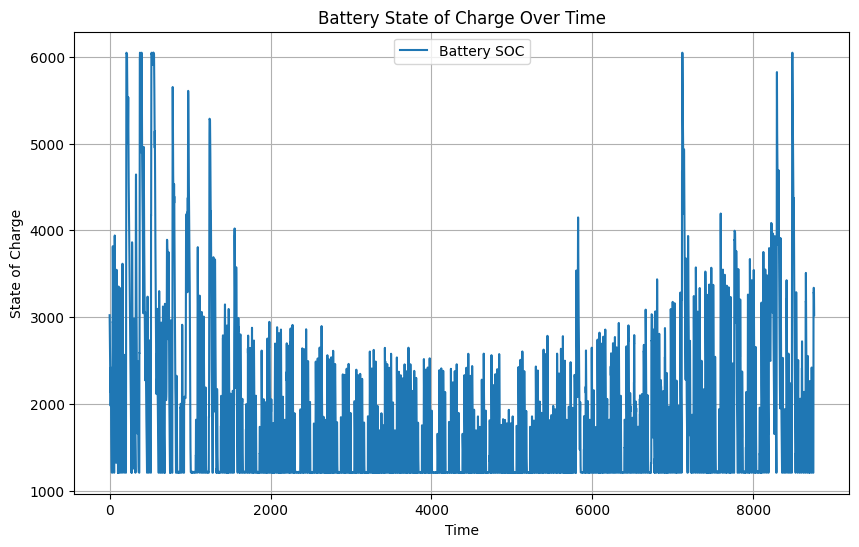

In [11]:
# Assuming model.T is your time range (e.g., hours in a day)
time = list(solution_output['B_SOC'].keys())  # Get the time points

# Example: Plot Battery State of Charge (B_SOC) over time
plt.figure(figsize=(10, 6))
plt.plot(time, solution_output['B_SOC'].values(), label='Battery SOC')
plt.xlabel('Time')
plt.ylabel('State of Charge')
plt.title('Battery State of Charge Over Time')
plt.grid(True)
plt.legend()
plt.show()

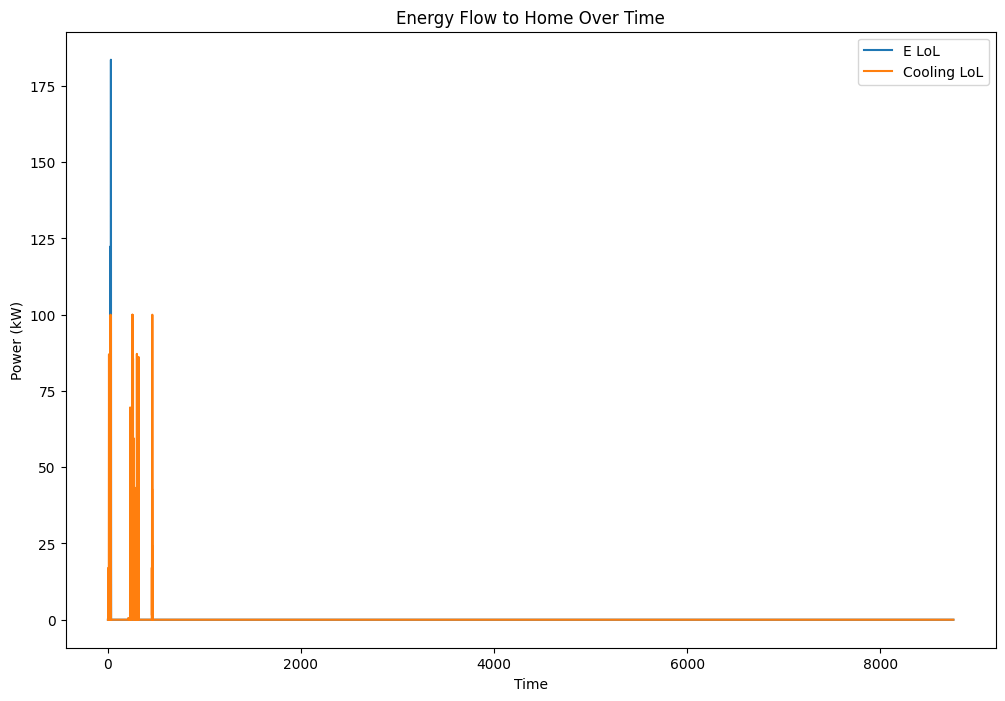

In [12]:
plt.figure(figsize=(12, 8))
time = list(solution_output['B_SOC'].keys())  # Get the time points
# Plot multiple variables
plt.plot(time, solution_output['G2E'].values(), label='E LoL')
plt.plot(time, solution_output['G2H'].values(), label='Cooling LoL')

plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Energy Flow to Home Over Time')
plt.legend()
plt.show()

In [14]:
total_G2E = sum(solution_output['G2E'].values())
print(f"Total G2E: {total_G2E}")
total_G2H = sum(solution_output['G2H'].values())
print(f"Total G2H: {total_G2H}")

Total G2E: 799.5708974859698
Total G2H: 3071.5155062384697
